# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math
import time

In [2]:
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.Graph()
B = nx.Graph()

In [5]:
roots = pickle.load(open('roots.p','rb'))

In [6]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore or isNaN(row['Combined_Genre']) or row['User'] not in roots: #removing reviews with low score 
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    album = row['Release'] + 'A'
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
            #B[user][genre]['concepts'].add((album,user))
        else:
            B.add_edge(user, genre, weight = 1)
            #B.add_edge(user, genre, weight = 1, concepts = {(album,user)})

In [7]:
B.number_of_nodes(), B.number_of_edges()

(1187, 2075)

[17, 17, 13, 11, 11, 11, 10, 10, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6]


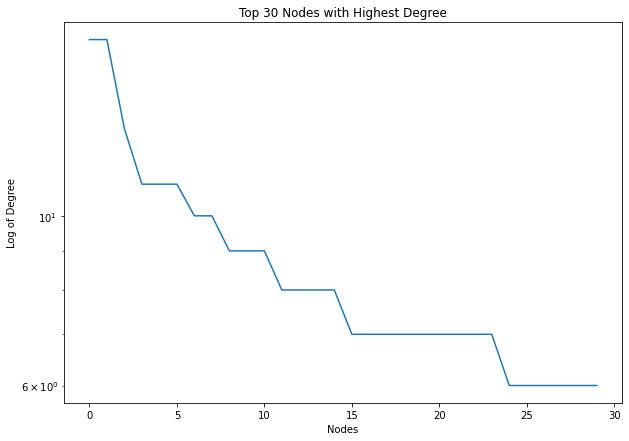

In [8]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[user] for user in users])[-30:]
tmp.reverse()
plt.semilogy(tmp)
print(tmp)
plt.show()

In [9]:
#removing structural holes
remove_users = set()
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        remove_users.add(user)
        users.remove(user)

In [16]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
                #G[genre1][genre2]['concepts'] = G[genre1][genre2]['concepts'].union(B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))
                #G[genre1][genre2]['users'].add(user)
            else:
                G.add_edge(genre1, genre2, weight = 1)
                #G.add_edge(genre1, genre2, weight = 1, concepts = B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))

In [17]:
G.number_of_nodes(), G.number_of_edges()

(172, 1291)

In [11]:
#nx.draw(G, node_size = 20)

In [12]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [13]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

In [14]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [18]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

172
124


In [13]:
G3 = G.copy()

In [19]:
Core = G3

In [20]:
Core.number_of_nodes(),Core.number_of_edges()

(124, 845)

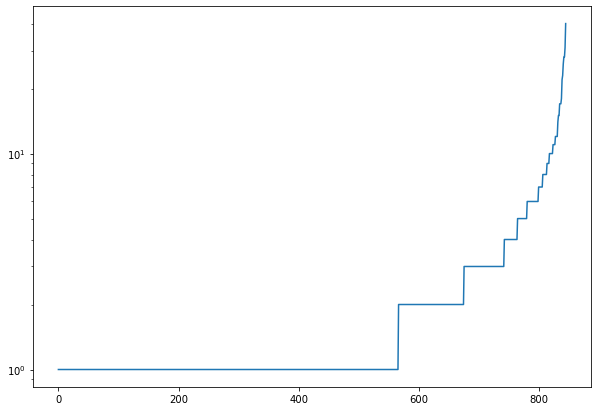

In [21]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))
plt.show()

In [21]:
#plt.hist(sorted(list(nx.get_edge_attributes(Core,'weight').values()))[:5000], log = True)

In [22]:
tmp = sorted([(v,u) for u,v in Core.degree])
#plt.xticks(rotation='')
#plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
#plt.plot([x[0] for x in tmp])
#plt.show()

In [23]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [24]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [25]:
def plotThreshold(Graph, thres):
    J = Graph.copy()
    for u,v in Graph.edges():
        if Graph[u][v]['weight'] < thres: #10 for double counting
            J.remove_edge(u,v)
    J.remove_nodes_from(list(nx.isolates(J)))
    L = J.copy()
    while not no_crossedges(L):
        L = freq_network_parr(L, 10, 4)
    print(thres,nx.number_connected_components(J),nx.number_connected_components(L),J.number_of_nodes())
    comps = nx.connected_components(L)
    part = {}
    for i,comp in enumerate(comps):
        for x in comp:
            part[x] = i
    #return modularity(part,J)
    inter = 0
    intra = 0
    for u,v in J.edges():
        if part[u] == part[v]:
            intra += 1
        else:
            inter += 1
            
    return inter/intra

'''plt.title('Modularity against Weight Threshold')
plt.ylabel('Modularity')
mods = [plotThreshold(Core.copy(), i) for i in range(15,25)]
plt.plot(mods)
plt.show()'''

"plt.title('Modularity against Weight Threshold')\nplt.ylabel('Modularity')\nmods = [plotThreshold(Core.copy(), i) for i in range(15,25)]\nplt.plot(mods)\nplt.show()"

In [26]:
#print(list(enumerate(mods)))

In [27]:
'''#Use modularity and Inter-Intra edges to determine weight threshold
#Use value of 20 (remove any edge below 20)
CoreNew = nx.Graph(Core)
edgeThres = 20
for u,v in Core.edges():
    if Core[u][v]['weight'] < edgeThres:
        CoreNew.remove_edge(u,v)
print(list(nx.isolates(CoreNew)))
CoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))
CoreNew.number_of_nodes(),CoreNew.number_of_edges()
CoreNew = Core
'''

"#Use modularity and Inter-Intra edges to determine weight threshold\n#Use value of 20 (remove any edge below 20)\nCoreNew = nx.Graph(Core)\nedgeThres = 20\nfor u,v in Core.edges():\n    if Core[u][v]['weight'] < edgeThres:\n        CoreNew.remove_edge(u,v)\nprint(list(nx.isolates(CoreNew)))\nCoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))\nCoreNew.number_of_nodes(),CoreNew.number_of_edges()\nCoreNew = Core\n"

In [27]:
#H = G.copy()
H = Core.copy()
#0.9 is good
#H = freq_network_parr(H, 100, 4, res = 0.8)
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

1 7626 845
1 7626 5039
1 7626 5039
4 2797 2104
4 2797 2104
4 2797 2062
4 2797 2062
5 1782 1782


In [28]:
partitions = [cc for cc in nx.connected_components(H)]

In [29]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [Core.subgraph(comp) for comp in comps]
    ave_weight = [sum([Core[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([Core[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([Core[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_coeff = [nx.average_clustering(Core, nodes = sub.nodes(), weight = 'weight') for sub in subgraphs]
    ave_coeff = [nx.average_clustering(sub, weight = 'weight') for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev, ave_coeff

In [30]:
[len(cc) for cc in partitions]

[35, 35, 19, 6, 29]

In [31]:
cluster = Core.subgraph(list(nx.connected_components(H))[0])
#nx.draw(cluster, node_size = 100,  font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)
#plt.show()

In [32]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'], ret['Average_Clustering_Coefficient'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{funeral doom metal, alternative thrash metal,...",35,2.284314,0.391597,0.171429,4.095376,0.038023
1,"{progressive stoner metal, extreme progressive...",35,2.728972,0.490756,0.179832,4.441878,0.062594
2,"{blackened speed metal, blackened doom metal, ...",19,2.204545,0.567251,0.257310,3.086477,0.069173
3,"{blackened death metal, stoner doom metal, bla...",6,1.222222,0.733333,0.600000,0.415740,0.385119
4,"{melodic death metal, gothic black metal, prog...",29,1.683673,0.406404,0.241379,1.723765,0.079835


In [46]:
clusters = [G.subgraph(list(cc)) for cc in nx.connected_components(H)]

2.284313725490196


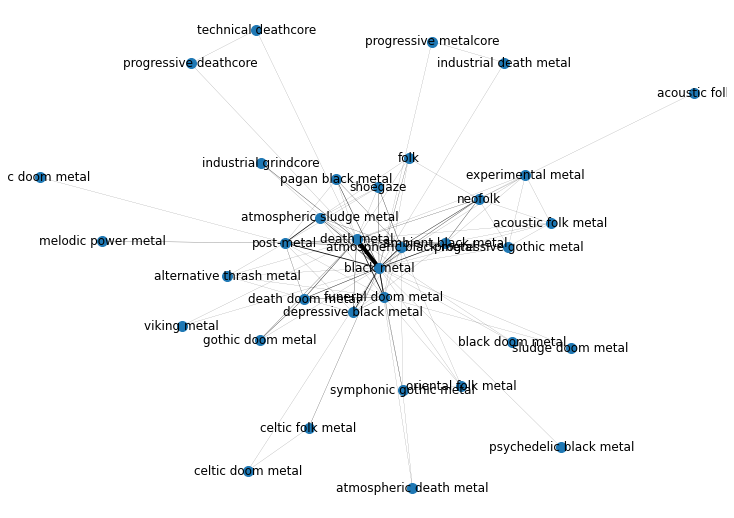


2.7289719626168223


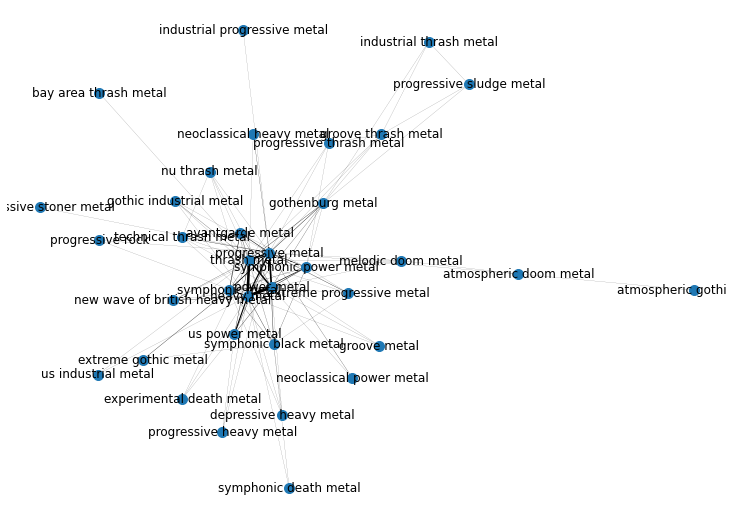


2.2045454545454546


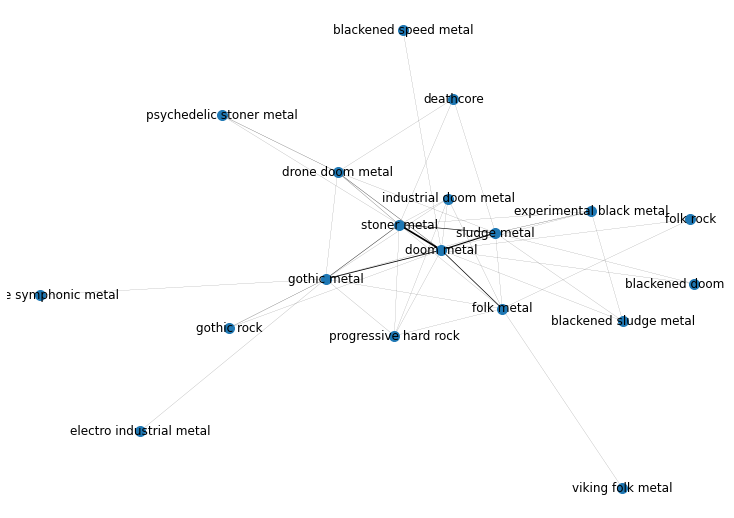


1.2222222222222223


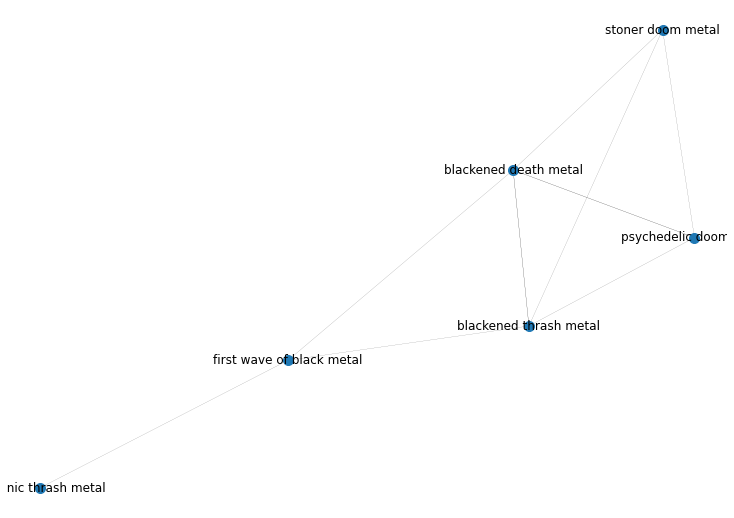


1.683673469387755


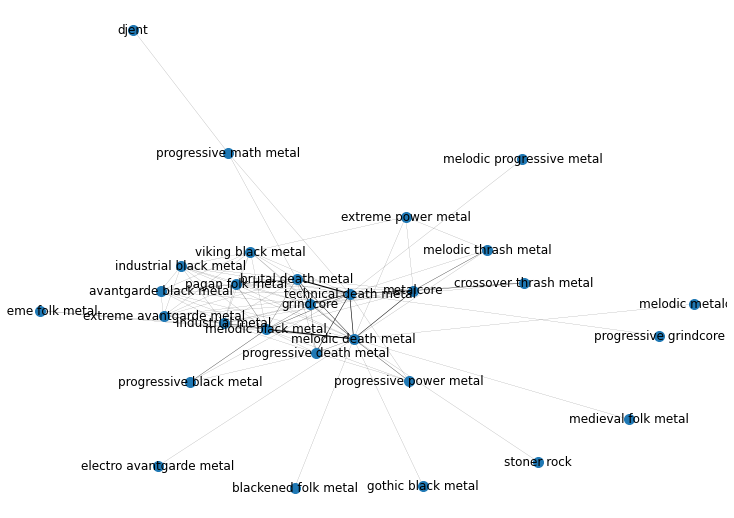

In [47]:
for i,cluster in enumerate(clusters):
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.1)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    plt.show()
    print()

In [48]:
clusters_new = []
inp = int(input('Enter Cluster ID to Keep: '))
clusters_new.append(G.subgraph(list(nx.connected_components(H))[inp]))

Enter Cluster ID to Keep:  3


In [49]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = Core.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 4)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        for comp in nx.connected_components(G1):
            clusters_new.append(Core.subgraph(comp))

In [50]:
inp = 0
tmp = []
inp = input('Enter Cluster IDs for Breakdown: ')
breakDown([int(x) for x in inp.split()])

Enter Cluster IDs for Breakdown:  0 1 2 4


1 595 102
4 227 185
4 227 185
5 164 164
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{death metal, funeral doom metal, viking metal...",15,3.34375,1.019048,0.304762,6.831038,0.058685
1,"{pagan black metal, acoustic folk, acoustic fo...",9,1.62500,0.722222,0.444444,0.992157,0.263333
2,"{atmospheric death metal, epic doom metal, sym...",7,2.40000,0.571429,0.238095,2.332381,0.000000
3,"{industrial death metal, progressive metalcore}",2,1.00000,1.000000,1.000000,0.000000,0.000000
4,"{technical deathcore, progressive deathcore}",2,1.00000,1.000000,1.000000,0.000000,0.000000


1 595 107
1 595 253
1 595 253
4 154 154
End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{progressive stoner metal, progressive metal, ...",13,1.428571,0.256410,0.179487,0.728431,0.109288
1,"{symphonic metal, extreme gothic metal, sympho...",7,1.818182,0.952381,0.523810,1.192262,0.235508
2,"{groove metal, gothic industrial metal, new wa...",10,4.952381,2.311111,0.466667,7.967052,0.110388
3,"{progressive sludge metal, progressive thrash ...",5,1.000000,0.700000,0.700000,0.000000,0.700000


1 171 44
2 123 115
2 123 115
4 42 42
End Clustering:  2


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{extreme symphonic metal, electro industrial m...",6,1.166667,0.466667,0.400000,0.372678,0.175000
1,"{psychedelic stoner metal, deathcore, drone do...",3,1.500000,1.000000,0.666667,0.500000,0.000000
2,"{blackened speed metal, blackened doom metal, ...",7,3.666667,2.095238,0.571429,4.972145,0.117559
3,"{folk rock, viking folk metal, folk metal}",3,1.000000,0.666667,0.666667,0.000000,0.000000


1 406 98
4 104 104
End Clustering:  4


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{technical death metal, melodic progressive me...",8,3.272727,1.285714,0.392857,3.164890,0.140401
1,"{industrial metal, extreme avantgarde metal, a...",6,1.000000,1.000000,1.000000,0.000000,1.000000
2,"{electro avantgarde metal, melodic death metal...",11,2.083333,0.454545,0.218182,2.498611,0.057134
3,"{crossover thrash metal, extreme power metal, ...",4,2.000000,1.333333,0.666667,1.000000,0.280437


In [37]:
#nx.write_gpickle(Core,'network_genres.p')

In [51]:
cluster_id = {}
for i,cluster in enumerate(clusters):
    for genre in cluster.nodes():
        cluster_id[genre] = i

In [52]:
len(clusters_new)

18

1.2222222222222223


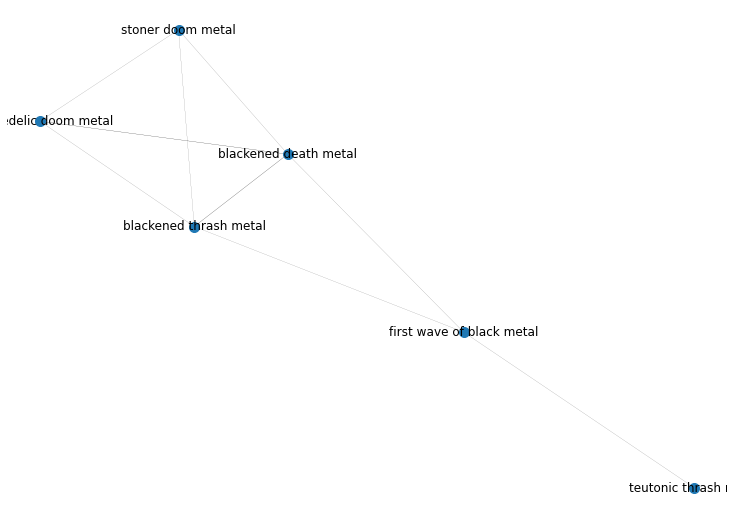


3.34375


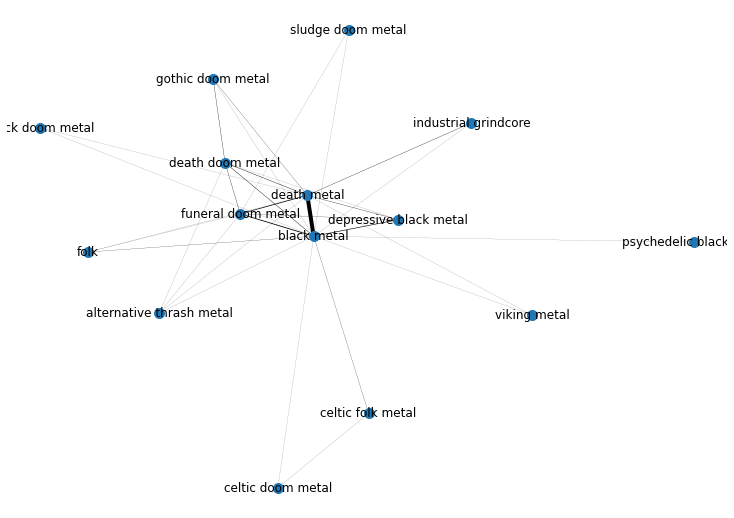


1.625


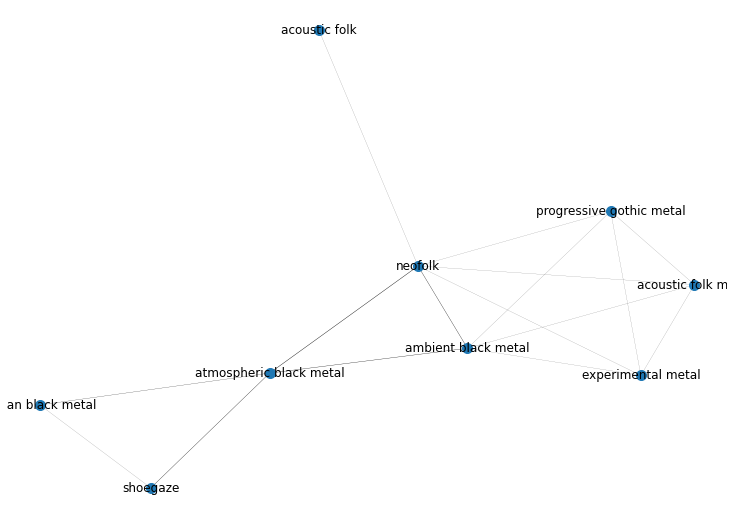


2.4


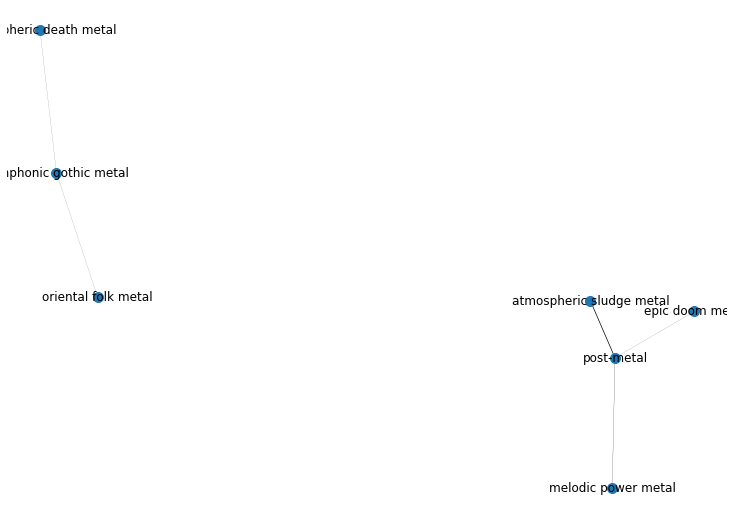


1.0


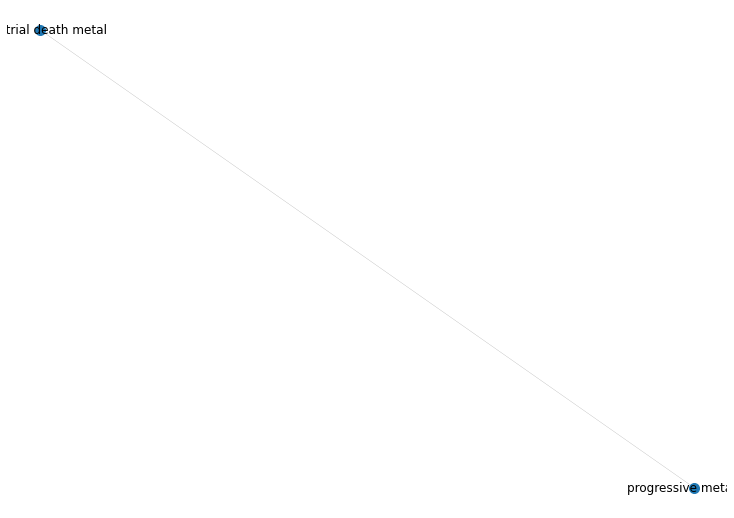


1.0


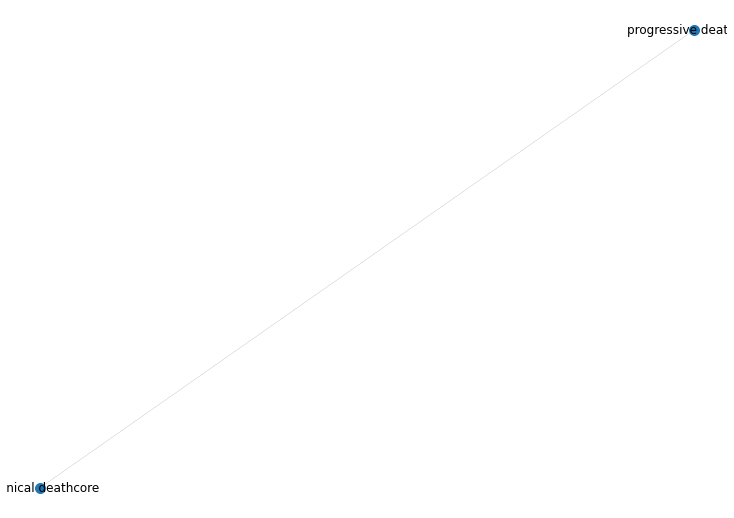


1.4285714285714286


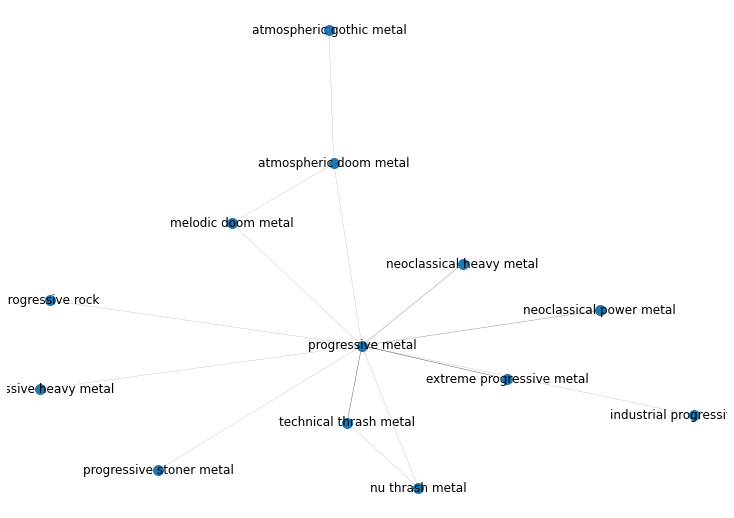


1.8181818181818181


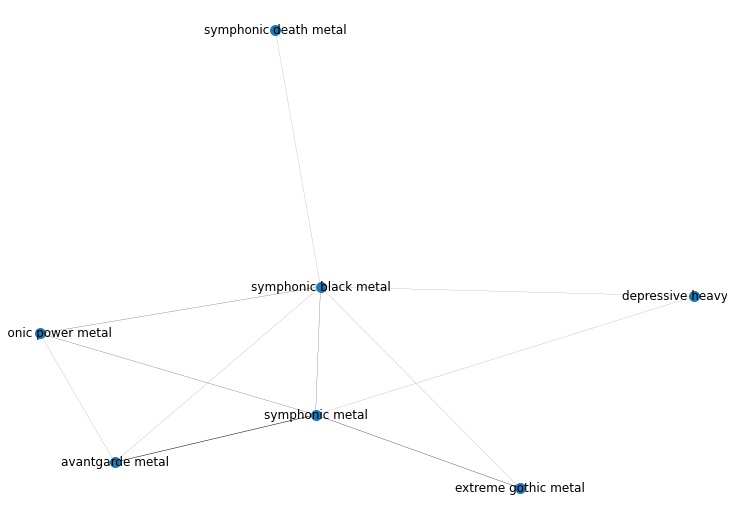


4.9523809523809526


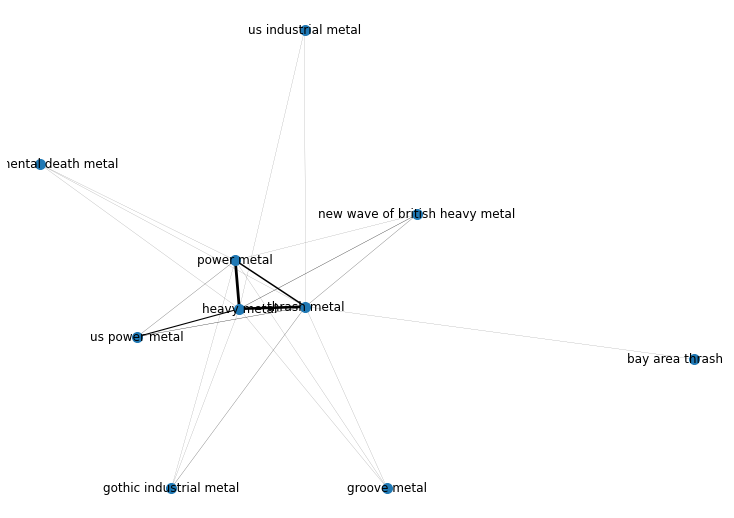


1.0


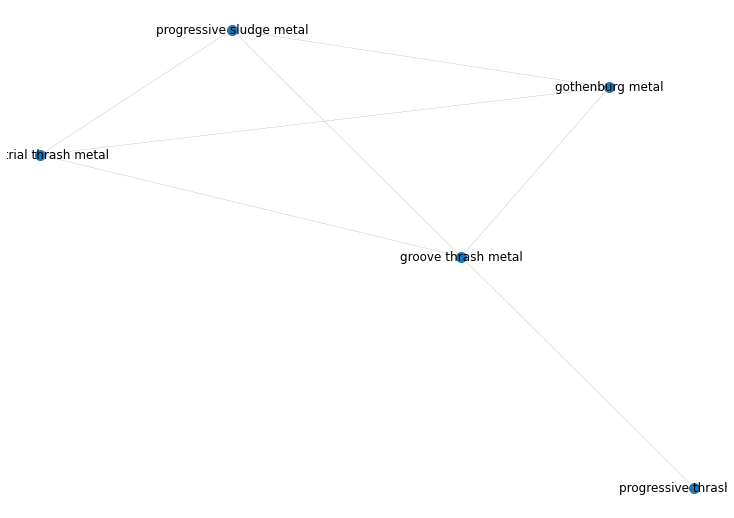


1.1666666666666667


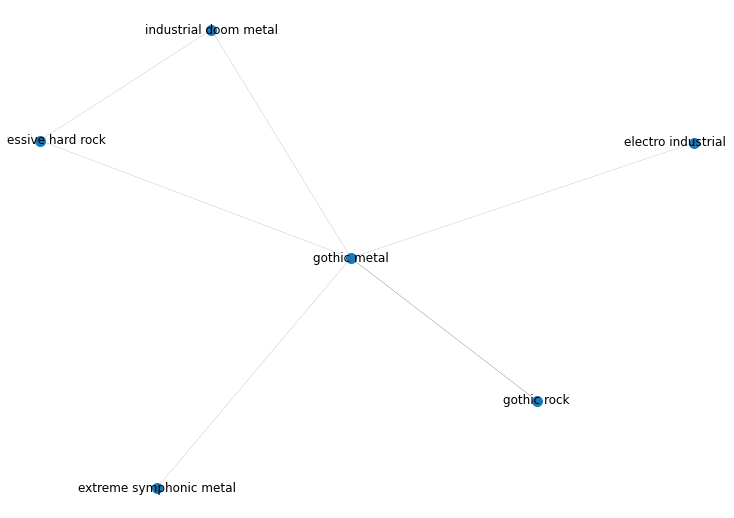


1.5


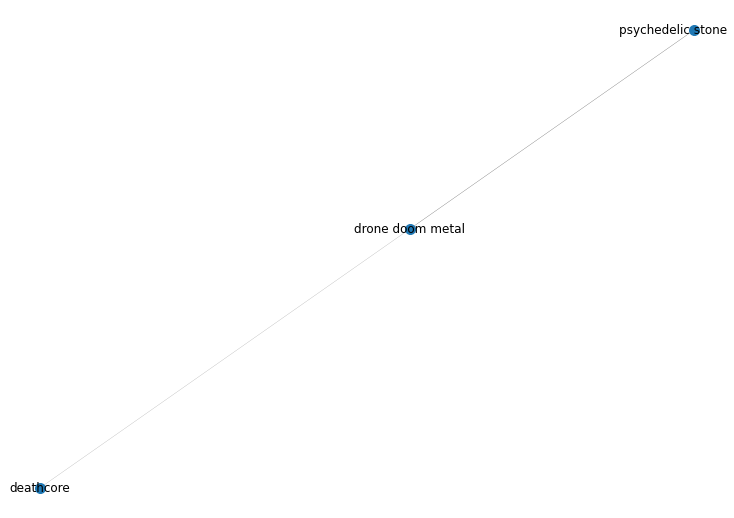


3.6666666666666665


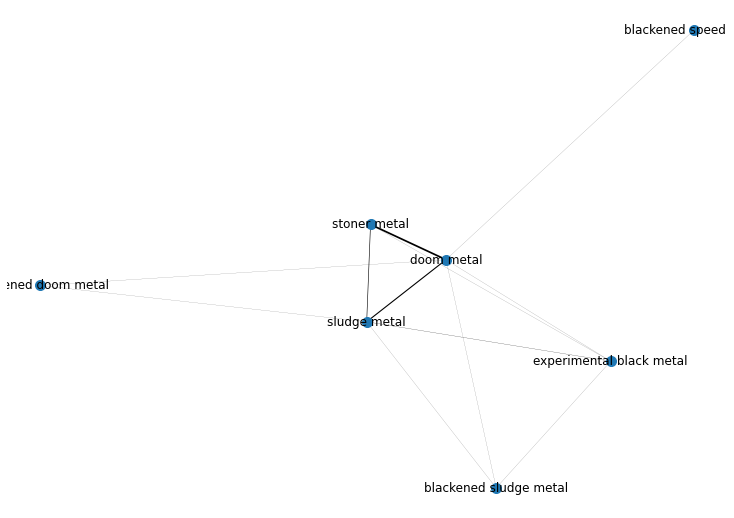


1.0


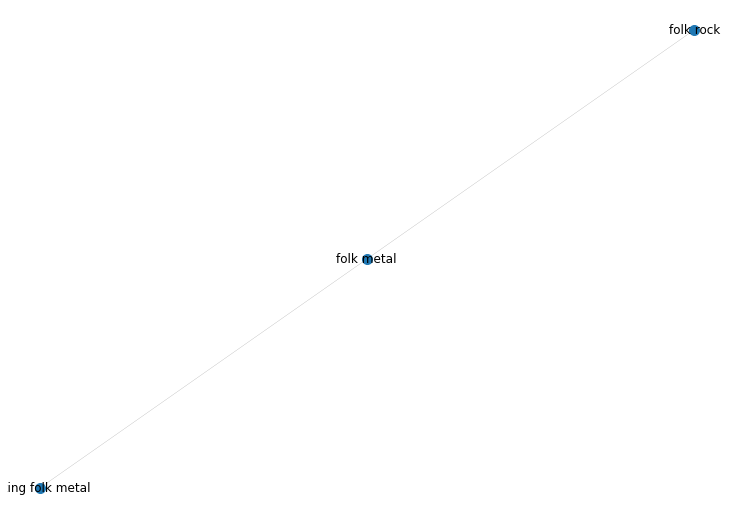


3.272727272727273


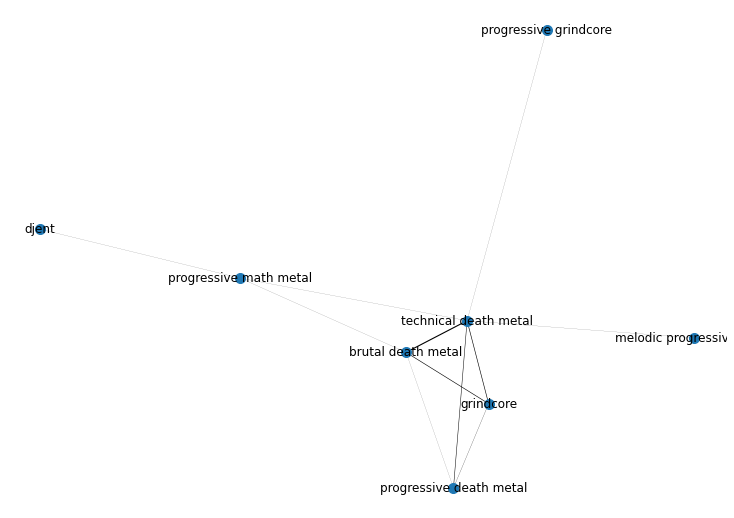


1.0


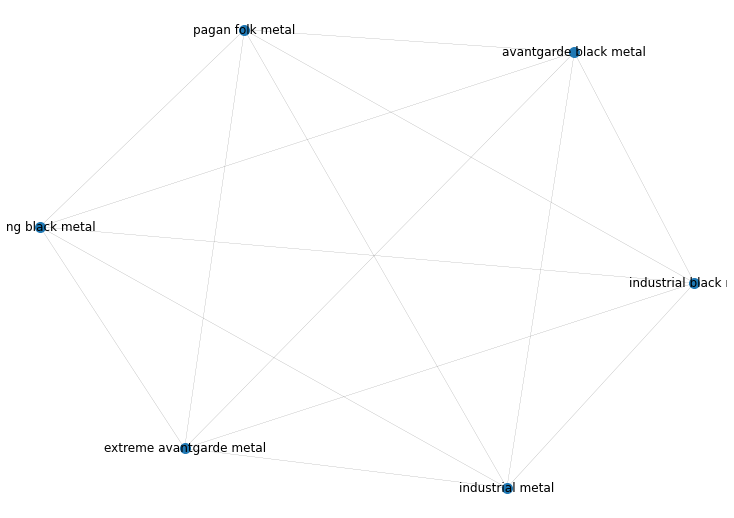


2.0833333333333335


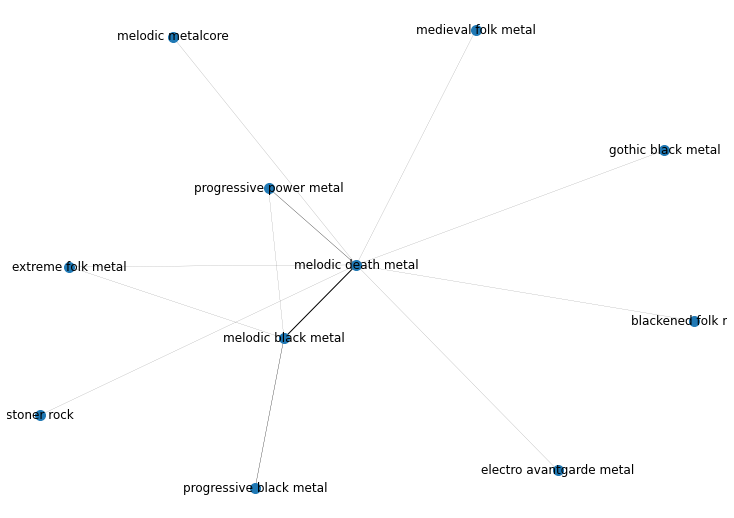


2.0


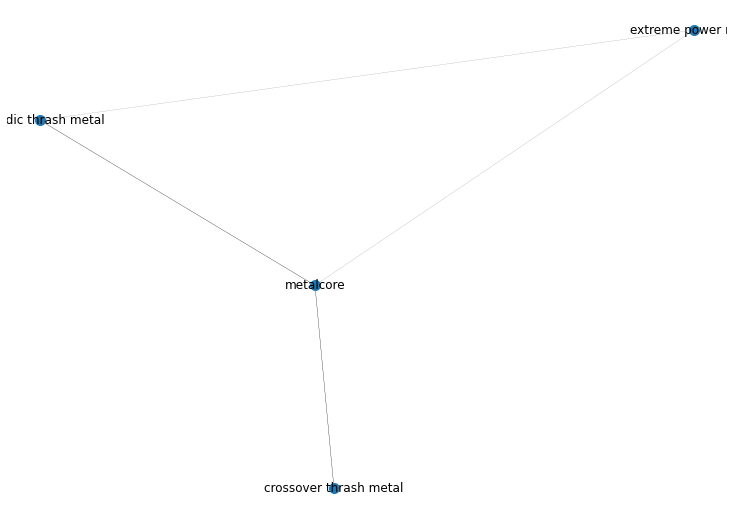

In [53]:
for i,cluster in enumerate(clusters_new):
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.1)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    plt.show()
    print()

In [54]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer() 
def isNaN(x):
    return x != x

def lem(x):
    return ' '.join([lemma.lemmatize(word) for word in x.split()])

In [55]:
t1 = time.time()
all_features = [{} for i in range(len(clusters))]

for i,row in df.iterrows():
    if isNaN(row['Combined_Genre']) or isNaN(row['Product Features_dep']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    if i%5000 == 0:
        print(i,time.time()-t1)
    feature_list = [lem(feature) for feature in row['Product Features_dep'].split('|') if 'metal' not in feature]
    cluster_ids = set([cluster_id[genre] for genre in genre_list if genre in cluster_id])
    for clus in cluster_ids:
        for phrase in feature_list:
            if phrase in all_features[clus]:
                all_features[clus][phrase] += 1
            else:
                all_features[clus][phrase] = 1

0 0.1865558624267578
5000 2.8298699855804443
20000 7.08690333366394
25000 8.570286273956299
30000 10.144750356674194
35000 11.786052227020264
40000 13.461690902709961
45000 15.067216634750366
50000 16.617340564727783
55000 18.12249445915222
60000 19.77491331100464
65000 21.451300859451294
70000 23.43433117866516
75000 25.56265926361084
85000 29.23621916770935


0 0.1403360366821289
10000 1.9756102561950684
20000 4.099044322967529
30000 6.210468053817749
40000 8.28408694267273
50000 10.565539360046387
60000 12.702846765518188
70000 15.207727670669556
80000 17.480093955993652
90000 19.598529815673828


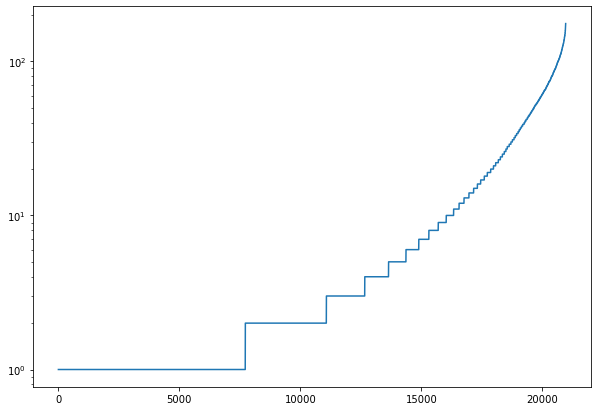

In [57]:
def isNaN(x):
    return x != x

adj_to_genre = {}
t1 = time.time()
all_genres = set()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Product Features_dep'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    for genre in genres.copy():
        if genre not in genre_group or genre_group[genre] == 'Non-metal' or genre_group[genre] == 'Others':
            genres.remove(genre)
    
    for feature in features:
        adj = lemma.lemmatize(feature.split(' ')[0])
        if adj not in adj_to_genre:
            adj_to_genre[adj] = set()
        for genre in genres:
            adj_to_genre[adj].add(genre)
            all_genres.add(genre)

genfreq = {}
for adj in adj_to_genre:
    if len(adj_to_genre[adj]) != 0:
        genfreq[adj] = len(adj_to_genre[adj])

plt.semilogy(sorted(genfreq.values()))
plt.show()    

In [62]:
#cxt is term frequency (tf)
idf = {}
for adj in genfreq:
    idf[adj] = math.log(len(all_genres)/genfreq[adj])

tfidf_list = []

for i, tf in enumerate(all_features):
    tfidf = {}
    for feature in tf:
        adj = feature.split(' ')[0]
        if adj not in idf:
            continue
        tfidf[feature] = tf[feature]*idf[adj]
    tfidf_list.append(tfidf)

Top 30 features for each cluster
2.284313725490196
['old school', 'double bass', 'clean vocal', 'acoustic guitar', 'female vocal', 'swedish band', 'harsh vocal', 'previous album', 'funeral doom', 'sound quality', 'rhythm guitar', 'entire album', 'norwegian band', 'guttural vocal', 'lead guitar', '21st century', 'subject matter', 'low end', 'little bit', 'final track', 'distorted guitar', 'black band', 'french band', 'lyrical theme', 'bad thing', 'norwegian scene', 'long time', 'spoken word', 'catchy riff', 'main riff']


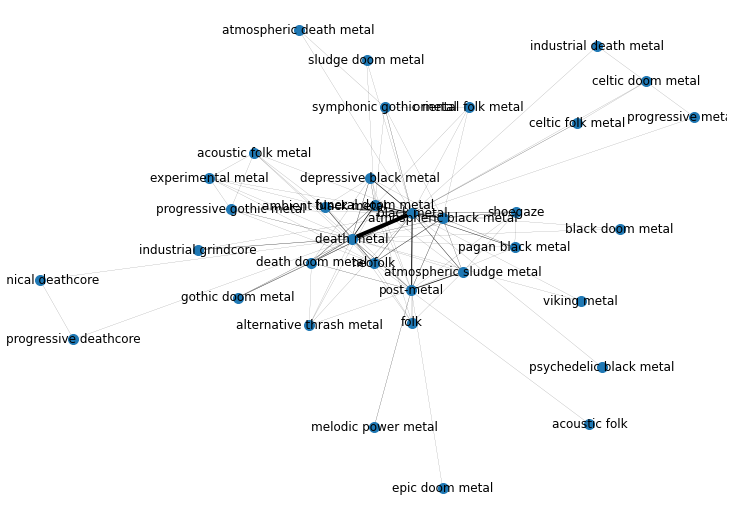


2.7289719626168223
['previous album', 'double bass', 'hard rock', 'best song', 'late 80', 'main riff', 'female vocal', 'live album', 'acoustic guitar', 'entire album', 'little bit', 'subject matter', 'catchy chorus', 'old school', 'rhythm guitar', 'harsh vocal', 'rhythm section', 'clean vocal', '21st century', 'favorite song', 'best album', 'long time', 'catchy riff', 'bad thing', 'vocal performance', 'lyrical theme', 'german band', 'lead guitar', 'past year', 'fastest song']


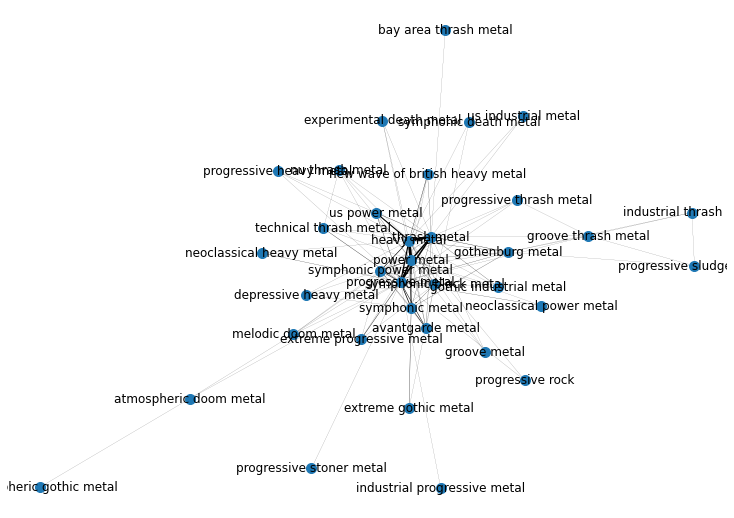


2.2045454545454546
['female vocal', 'clean vocal', 'harsh vocal', 'funeral doom', 'acoustic guitar', 'male vocal', 'previous album', 'gothic band', 'double bass', 'electric guitar', 'entire album', 'female vocalist', 'serial killer', 'subject matter', 'long time', 'little bit', 'distorted guitar', 'best song', 'main riff', 'lead guitar', 'rhythm guitar', 'operatic vocal', 'lyrical theme', 'heavy riff', 'rhythm section', 'favorite track', 'bad thing', 'final track', 'catchy riff', 'spoken word']


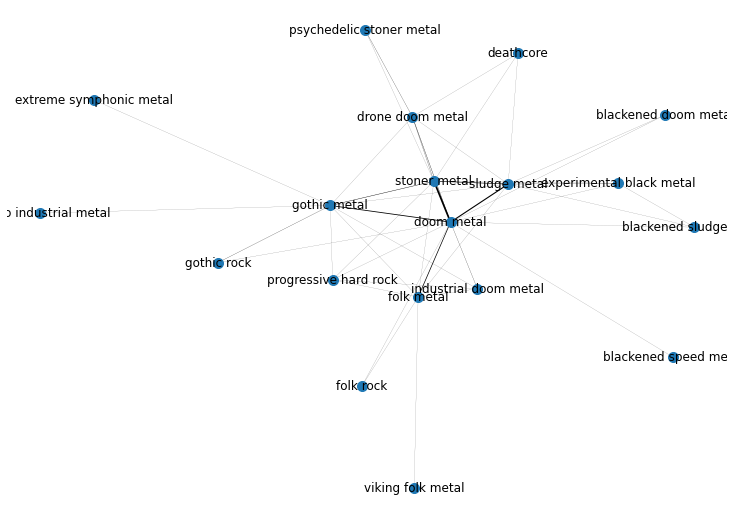


1.2222222222222223
['21st century', 'double bass', 'dissatisfied existence', 'main riff', 'previous album', 'teutonic thrash', 'old school', 'thrash riff', 'german band', 'live album', 'german thrash', 'black death', 'canadian band', 'rhythm guitar', 'proto death', 'behemoth fan', 'entire album', 'best song', 'black thrash', 'thrash album', 'lead guitar', 'little bit', 'fast riff', 'prime example', 'humble opinion', 'personal favorite', 'best album', 'acoustic guitar', 'bad thing', 'late 80']


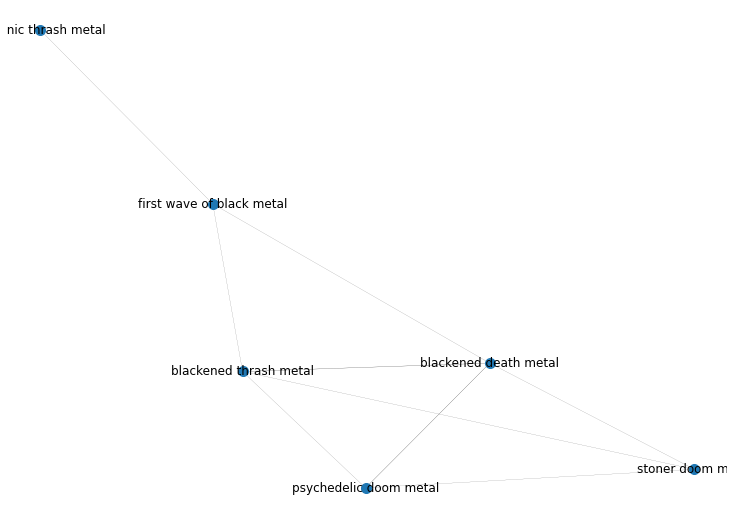


1.683673469387755
['clean vocal', 'double bass', 'harsh vocal', 'previous album', 'female vocal', 'entire album', 'acoustic guitar', 'guttural vocal', 'brutal band', 'little bit', 'catchy riff', 'rhythm guitar', 'bad thing', '21st century', 'best song', 'low end', 'favorite song', 'long time', 'guttural growl', 'swedish band', 'lyrical content', 'subject matter', 'lyrical theme', 'rhythm section', 'old school', 'best album', 'main riff', 'final track', 'lead guitar', 'previous release']


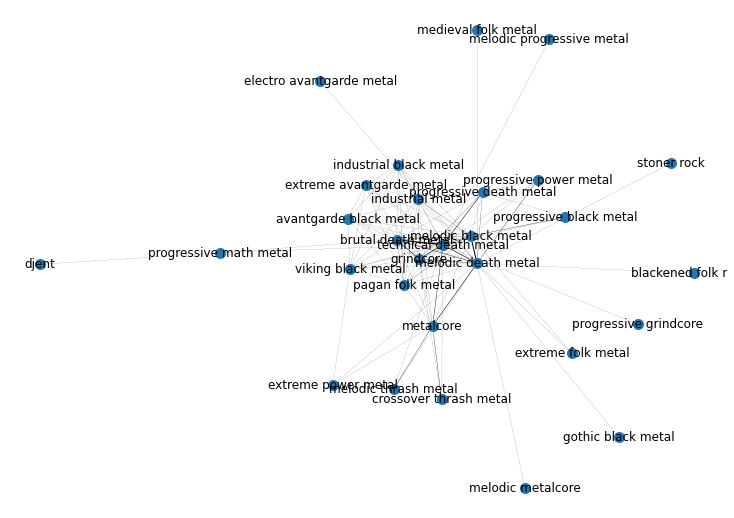

In [64]:
print('Top 30 features for each cluster')
for i,cluster in enumerate(clusters):
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.1)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    mp = {k: v for k, v in sorted(tfidf_list[i].items(), key=lambda item: item[1], reverse = True)}
    print(list(mp.keys())[:30])
    plt.show()
    print()

In [47]:
features_freq = pickle.load(open('opinionsv3.p','rb')) #sorted dictionary of phrases + frequency
print(len(features_freq))
genre_group = pickle.load(open('genre_group.p','rb'))

680777


In [49]:
cxt_raw = []
genres_all = []
features_all = set()
feat_to_gen = {}
t1 = time.time()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    featurelist = [feature for feature in row['Product Features_dep'].split('|') if 'metal' not in feature]
    genrelist = [genre for genre in row['Combined_Genre'].split('|') if genre in genre_group and genre_group[genre] != 'Non-metal' and genre_group[genre] != 'Others']
    for genre in genrelist:
        genre += ' (G)'
        for feature in featurelist:
            #if features_freq[feature] > 1:
            if True:
                feature = lem(feature)
                if feature not in feat_to_gen:
                    feat_to_gen[feature] = set()
                feat_to_gen[feature].add(genre)  
                cxt_raw.append((feature, genre))
                features_all.add(feature)
                genres_all.append(genre)
cxt = clt.Counter(cxt_raw)
genres_all = clt.Counter(genres_all)

0 0.14219999313354492
10000 3.7459487915039062
20000 6.780235290527344
30000 10.758318424224854
40000 15.278717041015625
50000 19.56587052345276
60000 24.207478284835815
70000 28.30270028114319
80000 32.07199692726135
90000 35.83403539657593


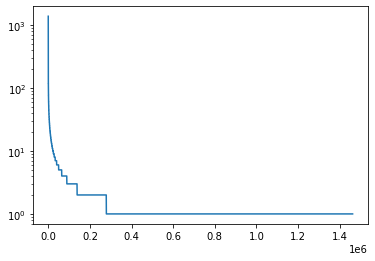

In [50]:
#plt.semilogy(sorted([cxt[(feature,genre)]/genres_all[genre] for feature, genre in cxt_freq], reverse = True))
plt.semilogy(sorted([cxt[(feature,genre)] for feature, genre in cxt], reverse = True))
plt.show()

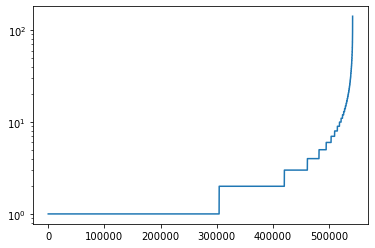

In [51]:
plt.semilogy(sorted([len(feat_to_gen[feature]) for feature in features_all]))
plt.show()

In [52]:
#cxt is term frequency (tf)
idf = {}
for adj in genfreq:
    idf[adj] = math.log(len(all_genres)/genfreq[adj])
tfidf = {}
for feature, genre in cxt:
    adj = feature.split(' ')[0]
    tfidf[(feature,genre)] = cxt[(feature,genre)]*idf[adj]

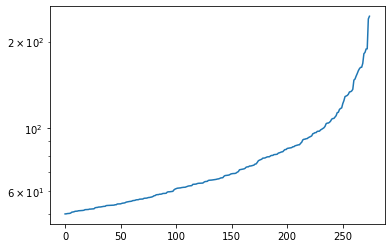

In [53]:
plt.semilogy([x for x in sorted(list(tfidf.values())) if x > 50])
plt.show()

In [54]:
from concepts import Context

In [55]:
thres = 20

genres_final = set(genre for feature, genre in tfidf if tfidf[(feature,genre)] >= thres)
features_final = set(feature for feature, genre in tfidf if tfidf[(feature,genre)] >= thres)
print(len(genres_final), len(features_final))

context_df = pd.DataFrame()
cnt = 0
for genre in genres_final:
    arr = []
    for feature in features_final:
        #if (feature, genre) in cxt and cxt[(feature,genre)]/genres_all[genre] >= 0.05:
        if (feature, genre) in cxt and tfidf[(feature,genre)] >= thres:
            cnt += 1
            arr.append('X')
        else:
            arr.append('')
    context_df[genre] = arr
context_df.index = list(features_final)
context_df.to_csv('fca.csv')
print(cnt)
context_df

38 900
1842


,black metal (G),symphonic power metal (G),atmospheric black metal (G),progressive power metal (G),progressive death metal (G),folk doom metal (G),progressive metal (G),gothenburg metal (G),melodic death metal (G),sludge metal (G),...,symphonic gothic metal (G),depressive black metal (G),viking black metal (G),brutal deathcore (G),heavy metal (G),teutonic thrash metal (G),brutal death metal (G),thrash metal (G),extreme power metal (G),avantgarde metal (G)
fuzzy guitar,X,,,,,,,,,,...,,,,,,,,,,
mid 80,,,,,,,,,,,...,,,,,X,,,X,,
nidrosian scene,X,,,,,,,,,,...,,,,,,,,,,
later album,X,,,,,,,,,,...,,,,,X,,,X,,
depressive act,X,,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
weakest song,,,,,,,,,,,...,,,,,X,,,,,
gruff vocal,,,,,,,,,,,...,,,,,X,,,X,,
chilling atmosphere,X,,,,,,,,,,...,,,,,,,,,,
weak song,,,,,,,,,,,...,,,,,X,,,,,


In [56]:
c = Context.fromfile('fca.csv', frmat = 'csv')
l = c.lattice

In [57]:
f = open('concepts_genres_phrases.txt','w')
for x,y in l:
    f.write(str(x) + '\n\n\n' + str(y) + '\n\n\n.....................\n\n\n')
    f.write('\n')
f.close()

In [58]:
x,y = l[90]
x,y,len(l)

(('fuzzy guitar',
  'distorted guitar',
  'subject matter',
  'double bass',
  'previous album',
  'female vocal',
  'entire album',
  'long time',
  'female vocalist',
  'low end',
  'little bit',
  'rhythm guitar',
  'serial killer',
  'lyrical theme',
  'favorite track',
  'slow riff',
  'acoustic guitar',
  'clean vocal',
  'sub genre',
  'main riff',
  'lead guitar',
  '21st century',
  'heavy riff',
  'operatic vocal',
  'harsh vocal',
  'funeral doom',
  'foulest semen',
  'rhythm section'),
 ('black metal (G)', 'doom metal (G)'),
 128)